In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import torch.nn as nn
import torch.optim as optim

## Braitenberg machine


In [31]:
class Braitenberg:
  """
  This class holds the genotype and position of the Braitenberg vehicle.
  """
  def __init__(self, initial_pos, initial_bearing, geno):
    self.geno = geno
    self.initial_bearing = initial_bearing
    self.pos = initial_pos

  def get_geno(self):
    return self.geno


## Environment settings

In [32]:
def add_gaussian_noise(data, mean=0.0, stddev=0.1):
  noise = np.random.normal(mean, stddev, data.shape)
  return data + noise

class Environment:
  """
  allows running of a trial in a set up environment
  """
  def __init__(self, sig=0.1, noise_stddev=0.1):
    # Initial setup
    self.dt = 0.05
    self.R = 0.05  # radius
    self.b = 45  # (degrees) sensor angle
    self.sig = sig
    self.noise_stddev = noise_stddev  # Noise standard deviation

  def run(self, T, agent, motor_gain=0.5, show=True, S=(0, 0)):
    """
      @param T is the time it will run for
      @param agent is the braitenberg vehicle object used
      @param show is whether it will show the plot
      @returns 2D array of positions the agent has traveled through [[x], [y]]
    """
    # convert geno params
    w_ll, w_lr, w_rl, w_rr, bl, br = agent.get_geno()
    sl_pos = np.zeros((2, 1))
    sr_pos = np.zeros((2, 1))
    S = np.array(S)
    rho = np.zeros((2, 1))
    sensor_gain = 0.5
    motor_gain = motor_gain
    vl = 0
    vr = 0
    # convert to radians

    initial_bearing = agent.initial_bearing / 360 * 2 * np.pi
    b = self.b / 360 * 2 * np.pi

    pos = np.zeros((2, int(T / self.dt)))
    bearing = np.zeros((1, int(T / self.dt)))
    pos[:, 0] = agent.pos
    bearing[:, 0] = initial_bearing
    lightIntensity = np.zeros((2, int(T / self.dt)))

    for i in range(1, int(T / self.dt)):
      vc = (vl + vr) / 2
      va = (vr - vl) / (2 * self.R)
      pos[0, i] = pos[0, i - 1] + self.dt * vc * np.cos(bearing[0, i - 1])
      pos[1, i] = pos[1, i - 1] + self.dt * vc * np.sin(bearing[0, i - 1])
      bearing[0, i] = np.mod(bearing[0, i - 1] + self.dt * va, 2 * np.pi)

      # Calculate left sensor position
      sl_pos[0] = pos[0, i] + self.R * np.cos(bearing[0, i] + b)
      sl_pos[1] = pos[1, i] + self.R * np.sin(bearing[0, i] + b)

      # Calculate right sensor position
      sr_pos[0] = pos[0, i] + self.R * np.cos(bearing[0, i] - b)
      sr_pos[1] = pos[1, i] + self.R * np.sin(bearing[0, i] - b)

      # Calculate (square) distance to element
      # this code assumes light is always at S
      dl = np.sqrt((sl_pos[0] - S[0]) ** 2 + (sl_pos[1] - S[1]) ** 2)
      dr = np.sqrt((sr_pos[0] - S[0]) ** 2 + (sr_pos[1] - S[1]) ** 2)

      # Calculate local intensity
      il = sensor_gain / dl
      ir = sensor_gain / dr
      lightIntensity[0, i] = il
      lightIntensity[1, i] = ir
      # weights times inputs plus bias
      lm = il * w_ll + ir * w_rl + bl
      rm = il * w_lr + ir * w_rr + br
      # add a some gaussian noise to each motor.
      # The sig variable controls how much noise is added
      lm = lm + np.random.normal(0, self.sig)
      rm = rm + np.random.normal(0, self.sig)

      # Scale by motor gains
      vl = motor_gain * lm
      vr = motor_gain * rm

    # Add Gaussian noise to the final positions
    pos = add_gaussian_noise(pos, mean=0.0, stddev=self.noise_stddev)

    if show:
      self.show(T, pos, sl_pos, sr_pos, bearing, b)
    return pos, lightIntensity

  def show(self, T, pos, sl_pos, sr_pos, bearing, b):
    plt.plot(pos[0, :], pos[1, :])
    # final position
    x = pos[0, int(T / self.dt) - 1]
    y = pos[1, int(T / self.dt) - 1]
    f_bearing = bearing[0, int(T / self.dt) - 1]
    # Calculate left sensor position
    sl_pos[0] = x + self.R * np.cos(f_bearing + b)
    sl_pos[1] = y + self.R * np.sin(f_bearing + b)
    # Calculate right sensor position
    sr_pos[0] = x + self.R * np.cos(f_bearing - b)
    sr_pos[1] = y + self.R * np.sin(f_bearing - b)

    plt.plot(0, 0, marker='.', markersize=30, color='yellow')
    plt.plot(0, 0, marker='o', markersize=10, color='black')

    # Plot sensors
    plt.plot(sl_pos[0], sl_pos[1], marker='.', markersize=10, color='red')
    plt.plot(sr_pos[0], sr_pos[1], marker='.', markersize=10, color='red')

    # Plot body
    plt.plot(x, y, marker='.', markersize=10, color='blue')
    plt.plot(x, y, marker='o', markersize=10, color='black')
    # Plot trajectory
    plt.pause(0.05)

    return pos

## Genetic Algorithms (GAs)


integrate the common part of the both GA

In [21]:

class EvolutionaryAlgorithm:
    def __init__(self, generations=100, population_size=100, max_value=5, min_value=0, mutation_mean=0, mutation_std=0.1):
        """
        Initializes the evolutionary algorithm parameters.
        """
        self.generations = generations  # Number of generations to run the algorithm
        self.population_size = population_size  # Size of the population
        self.max_value = max_value  # Maximum value for the genotype elements
        self.min_value = min_value  # Minimum value for the genotype elements
        self.mutation_mean = mutation_mean  # Mean value for the mutation noise
        self.mutation_std = mutation_std  # Standard deviation for the mutation noise

    def generate_genotype(self):
        """
        Generates a random genotype with values between 0 and max_value.
        """
        return np.random.rand(6) * self.max_value

    def initialize_population(self):
        """
        Initializes the population with random genotypes.
        """
        return [self.generate_genotype() for _ in range(self.population_size)]

    def mutate(self, genotype):
        """
        Mutates the given genotype by adding Gaussian noise.
        """
        mutated_genotype = copy.deepcopy(genotype)  # Create a deep copy of the genotype
        noise = np.random.normal(self.mutation_mean, self.mutation_std, size=mutated_genotype.shape)  # Generate Gaussian noise
        mutated_genotype += noise  # Add noise to the genotype

        # Ensure the genotype values are within the allowed range
        mutated_genotype[mutated_genotype > self.max_value] = self.max_value
        mutated_genotype[mutated_genotype < self.min_value] = self.min_value

        return mutated_genotype

    def fitness(self, positions, intensities, lightsource=(0, 0)):
        """
        Calculates the fitness of an agent based on its distance to the light source.
        """
        start_dist = np.linalg.norm(positions[:, 0] - np.array(lightsource))  # Distance at the start
        end_dist = np.linalg.norm(positions[:, -1] - np.array(lightsource))  # Distance at the end
        distance_gained = start_dist - end_dist  # Distance gained towards the light source
        return distance_gained / start_dist  # Normalize the distance gained

    def evaluate_fitness(self, population, env, starting_position, starting_bearing, runtime):
        """
        Evaluates the fitness of each individual in the population.
        """
        fitness_scores = []

        for genotype in population:
            # Create an agent with the given genotype
            agent = Braitenberg(starting_position, starting_bearing, genotype)

            # Run the agent in the environment
            trajectory, intensities = env.run(runtime, agent, show=False)

            # Calculate and store the fitness score
            fitness_scores.append(self.fitness(trajectory, intensities))

        return np.array(fitness_scores)  # Return the fitness scores as a numpy array

    def run(self, starting_position, starting_bearing, env, runtime=5, track_fitness=False):
        """
        Runs the evolutionary algorithm for a specified number of generations.
        """
        population = self.initialize_population()  # Initialize the population
        fitness_trend = []

        for generation in range(self.generations):
            # Evaluate fitness
            fitness_scores = self.evaluate_fitness(population, env, starting_position, starting_bearing, runtime)

            if track_fitness:
                # Track the maximum fitness score
                fitness_trend.append(np.max(fitness_scores))

            # Evolve the population
            new_population = self.evolve_population(population, fitness_scores)
            population = new_population  # Update the population

        # Find the index of the best individual
        best_index = np.argmax(fitness_scores)

        if track_fitness:
            # Return the best individual and fitness trend if tracking fitness
            return population[best_index], fitness_scores[best_index], fitness_trend

        # Return the best individual
        return population[best_index], fitness_scores[best_index]

    def evolve_population(self, population, fitness_scores):
        """
        Placeholder for population evolution logic, to be implemented by subclasses.
        """
        raise NotImplementedError("This method should be overridden by subclasses")


Full microbial GA

In [22]:
class FullMicrobialGA(EvolutionaryAlgorithm):
    """
    Full Microbial Genetic Algorithm (GA) class inheriting from a generic EvolutionaryAlgorithm.
    This class implements a GA where a portion of the population is preserved (elitism) and the rest
    is evolved through a microbial approach.
    """

    def __init__(self, generations=100, population_size=100, max_value=5, min_value=0, mutation_mean=0, mutation_std=0.1, elitism_count=10):
        """
        Initializes the FullMicrobialGA with given parameters, setting up the number of elite individuals to preserve.
        """
        super().__init__(generations, population_size, max_value, min_value, mutation_mean, mutation_std)
        self.elitism_count = elitism_count

    def evolve_population(self, population, fitness_scores):
        """
        Evolves the population by preserving the top individuals and evolving the rest
        using a microbial approach where pairs of individuals are compared, and the fitter one is mutated.
        """
        # Sort the population by fitness scores in descending order
        sorted_indices = np.argsort(fitness_scores)[::-1]
        new_population = [population[i] for i in sorted_indices[:self.elitism_count]]

        # Evolve the rest of the population
        while len(new_population) < self.population_size:
            a = np.random.randint(0, self.population_size)
            b = np.random.randint(0, self.population_size)
            if fitness_scores[a] > fitness_scores[b]:
                new_individual = self.mutate(population[a])
            else:
                new_individual = self.mutate(population[b])
            new_population.append(new_individual)

        return new_population


Spatial GA

In [23]:
class SpatialGA(EvolutionaryAlgorithm):
    """
    Spatial Genetic Algorithm (GA) class inheriting from a generic EvolutionaryAlgorithm.
    This class implements a GA with a spatial structure where individuals are arranged in a grid,
    and only interact with their neighbors.
    """

    def __init__(self, population_size=10, generations=100, runtime=5, grid_size=None, max_value=5, min_value=0, mutation_mean=0, mutation_std=0.1):
        """
        Initializes the SpatialGA with given parameters, setting up the grid size based on the population size
        if grid_size is not explicitly provided.
        """
        super().__init__(generations, population_size, max_value, min_value, mutation_mean, mutation_std)
        self.runtime = runtime

        # If grid_size is not provided, calculate it based on population_size
        if grid_size is None:
            side_length = int(np.sqrt(population_size))
            if side_length * side_length < population_size:
                side_length += 1
            self.grid_size = (side_length, side_length)
        else:
            self.grid_size = grid_size

        assert self.grid_size[0] * self.grid_size[1] >= population_size, "Grid size must be at least as large as the population size"

    def get_neighbors(self, index):
        """
        Determines the neighbors of an individual in the grid based on its index.
        """
        x, y = index % self.grid_size[0], index // self.grid_size[0]
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                nx, ny = (x + dx) % self.grid_size[0], (y + dy) % self.grid_size[1]
                neighbor_index = ny * self.grid_size[0] + nx
                if neighbor_index < self.population_size:
                    neighbors.append(neighbor_index)
        return neighbors

    def evolve_population(self, population, fitness_scores):
        """
        Evolves the population by selecting the best neighboring individual for each individual
        and potentially applying a mutation.
        """
        new_population = population[:]
        for i in range(self.population_size):
            neighbors = self.get_neighbors(i)
            neighbor_fitness = [fitness_scores[n] for n in neighbors]
            best_neighbor = neighbors[np.argmax(neighbor_fitness)]
            if fitness_scores[i] < fitness_scores[best_neighbor]:
                new_population[i] = self.mutate(population[best_neighbor])
        return new_population


Setup genotype phenotype encoding

In [29]:
class DirectEncoding:
  """
    Determine the genotype phenotype encoding.
    utilize only direct encoding
  """
  def encode(self, genotype):
    return genotype


## Experiment runner

In [36]:

def plot_trajectories(trajectories, light_source, title):
    """
    Plots the trajectories of agents on a 2D plane.
    Each trajectory is represented with a start and end point.
    The light source is also marked on the plot.
    """
    plt.figure()
    for trajectory, label in trajectories:
        plt.plot(trajectory[0], trajectory[1], label=label)
        plt.scatter(trajectory[0][0], trajectory[1][0], color='green')  # Start
        plt.scatter(trajectory[0][-1], trajectory[1][-1], color='red')  # End
    plt.scatter(light_source[0], light_source[1], color='yellow', s=100, label='Light Source', edgecolors='black')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend(loc='upper left', framealpha=0.7)
    plt.grid(True)
    plt.show()

def plot_fitness_trends(fitness_trends, title):
    """
    Plots the fitness trends over generations for multiple GA runs.
    Each trend is smoothed using a moving average for clarity.
    """
    fig, axes = plt.subplots(len(fitness_trends), 1, figsize=(10, 15), sharex=True)
    for ax, (fitness, label) in zip(axes, fitness_trends):
        window_size = 5
        moving_avg = np.convolve(fitness, np.ones(window_size)/window_size, mode='valid')
        ax.plot(moving_avg, label=label)
        ax.set_ylim([0.0, 1.0])  # Fixed scale for fitness
        ax.set_title(label)
        ax.set_ylabel('Fitness')
        ax.grid(True)
    plt.xlabel('Generation')
    plt.suptitle(title)
    plt.show()

def save_results(filename, genotype, fitness):
    """
    Saves the best genotype and fitness score to a text file.
    """
    with open(filename, 'w') as file:
        file.write(f'Best Genotype: {genotype}\n')
        file.write(f'Best Fitness: {fitness}\n')

def run_ga_algorithm(ga_algorithm, utils, encoder, starting_position, starting_bearing, env, runtime, noise_stddev, encoding_method):
    """
    Runs the genetic algorithm and returns the best trajectory, fitness, fitness trend, and genotype.
    The best genotype is encoded and used to simulate the agent in the environment.
    """
    best_genotype, best_fitness, fitness_trend = ga_algorithm.run(starting_position, starting_bearing, env, track_fitness=True)
    encoded_genotype = encoder.encode(best_genotype)
    agent = Braitenberg(starting_position, starting_bearing, encoded_genotype)
    trajectory, _ = env.run(runtime, agent, show=False)
    return trajectory, best_fitness, fitness_trend, best_genotype



<ipython-input-32-53e6d95f06db>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0, i] = il
<ipython-input-32-53e6d95f06db>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1, i] = ir
<ipython-input-32-53e6d95f06db>:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0, i] = pos[0, i - 1] + self.dt * vc * np.cos(bearing[0, i - 1])
<ipython-input-32-53e6d95f06db>:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scal

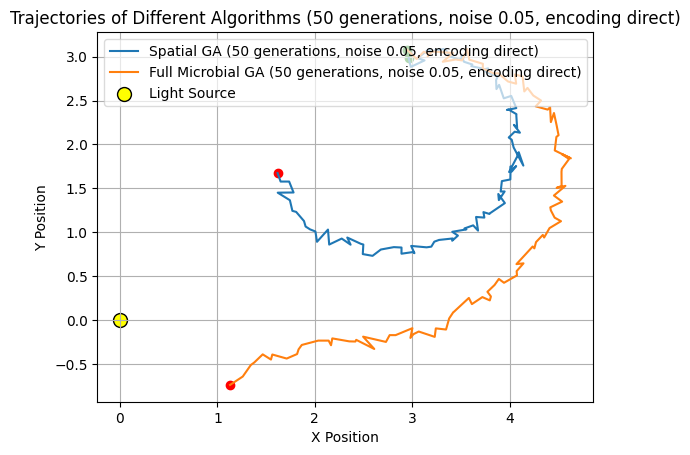

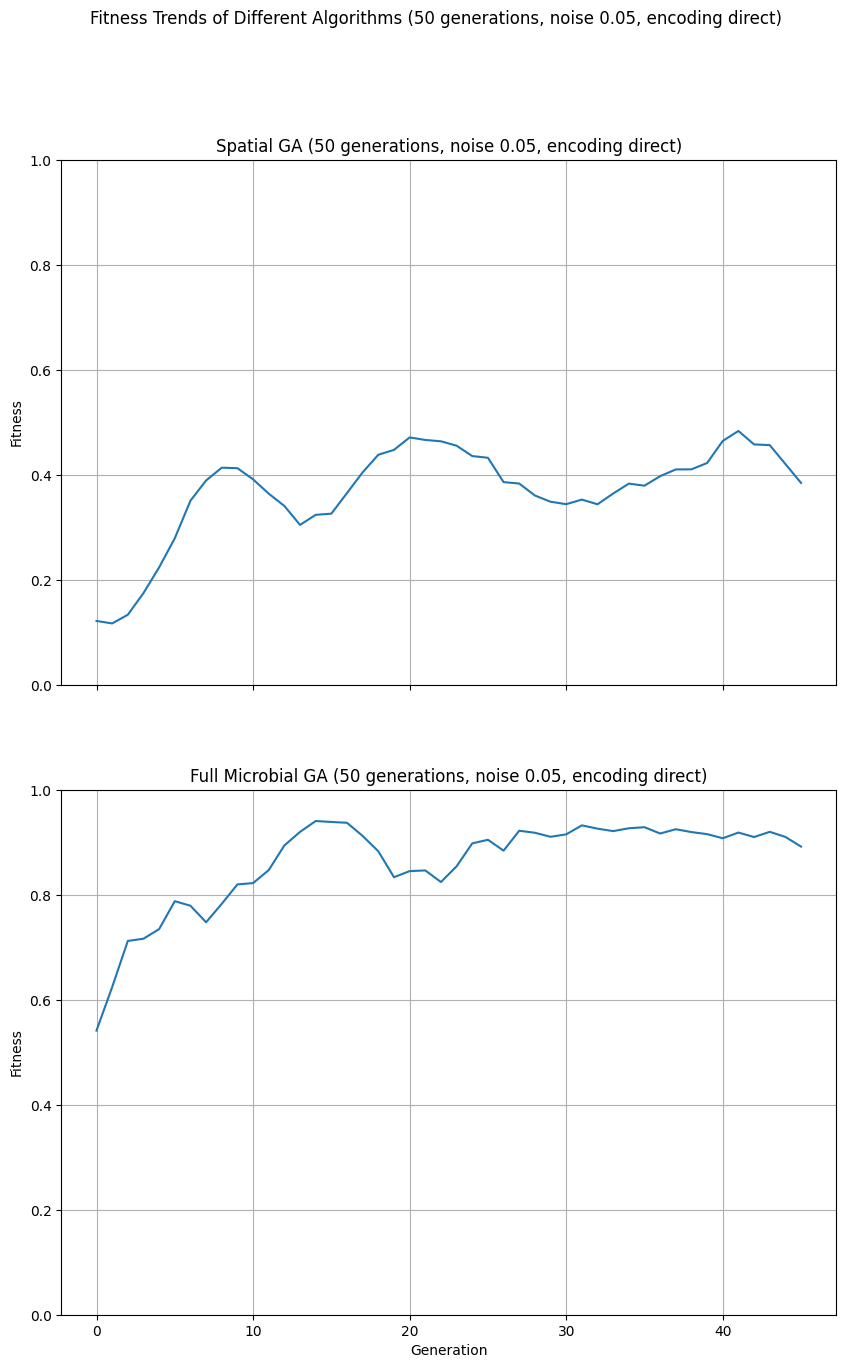

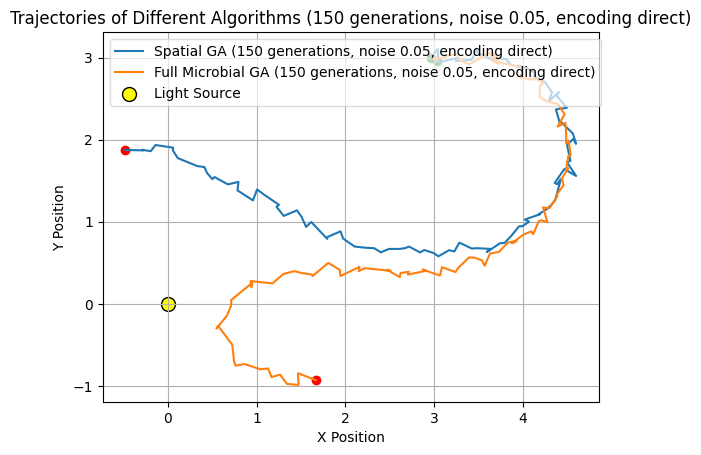

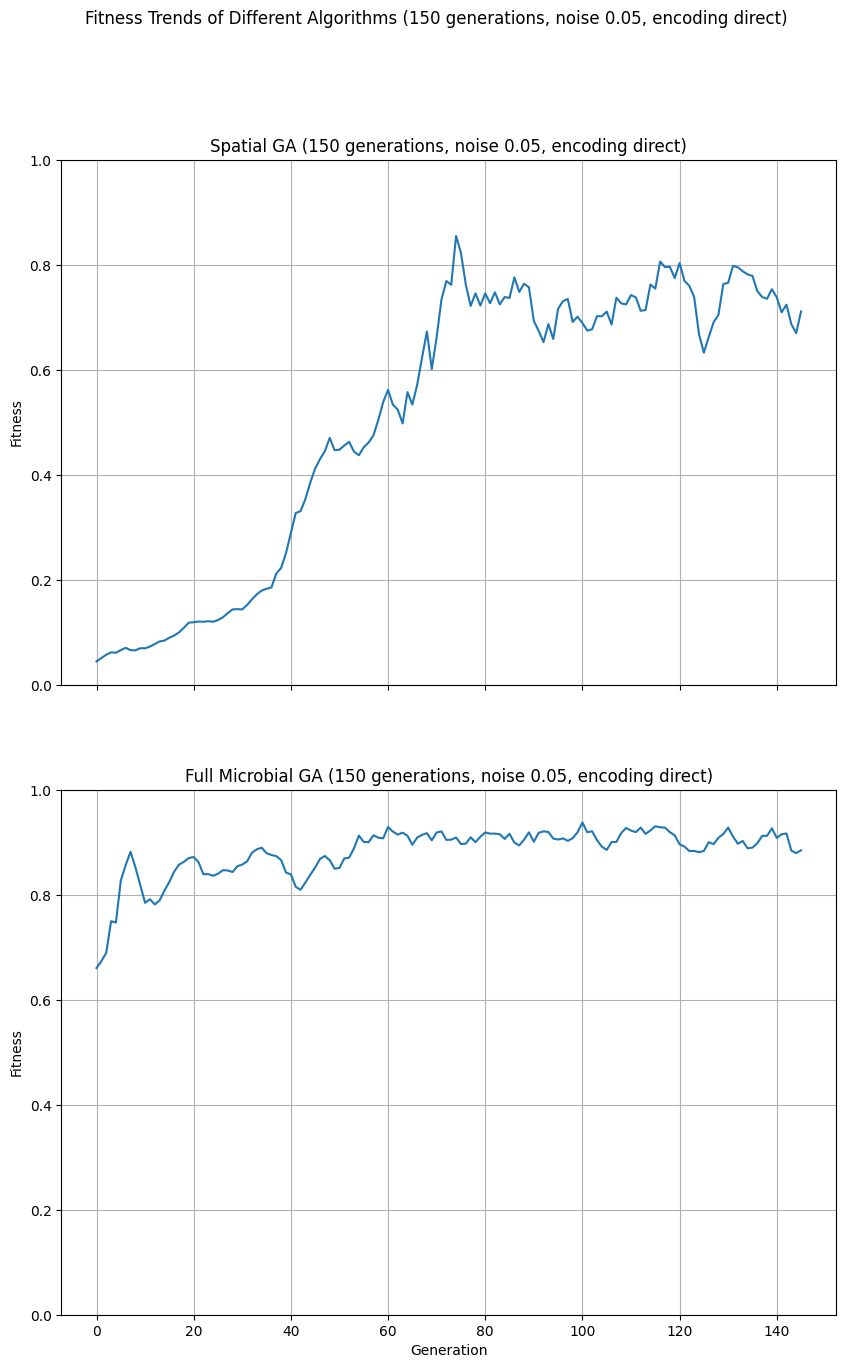

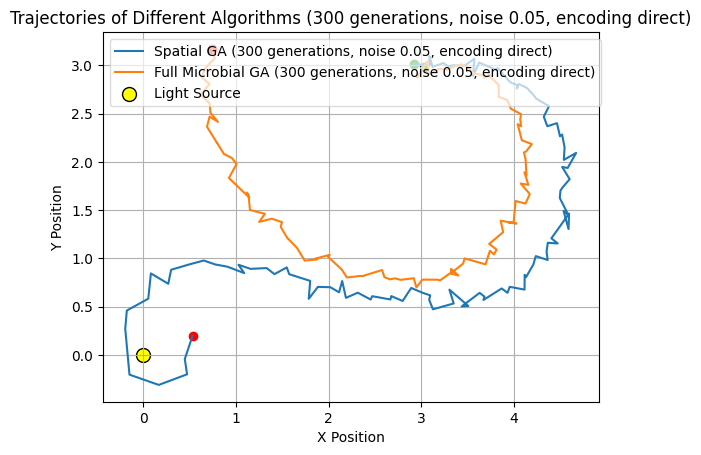

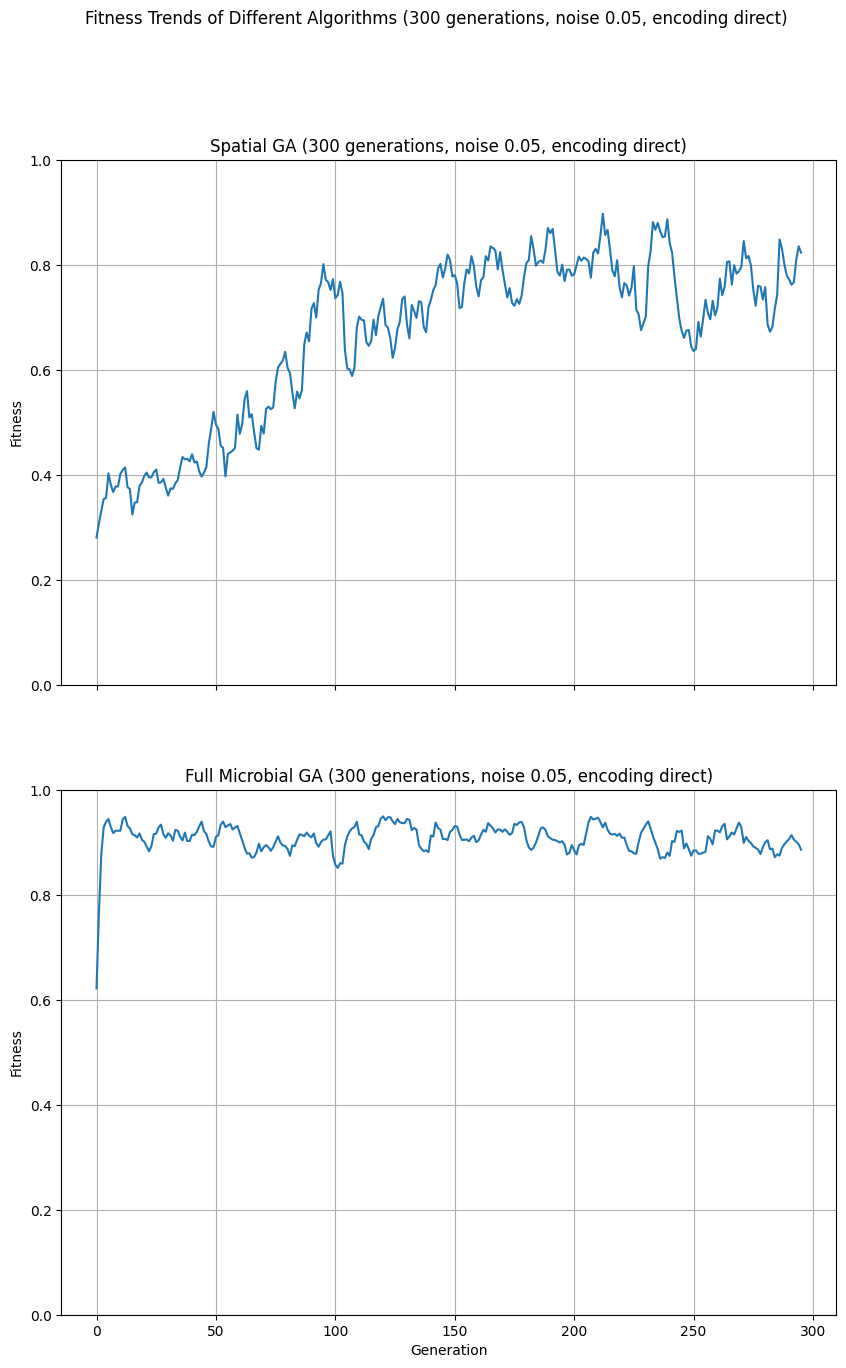

In [37]:
# Parameters for the GA run
starting_position = (3, 3)
starting_bearing = 10
runtime = 5
light_source = (0, 0)

# Generations to test
generations_list = [50, 150, 300]

# Noise levels to test
noise_levels = [0.05]

# Encoding methods to test
encoding_method = "direct"
encoder = DirectEncoding()

for noise_stddev in noise_levels:
    env = Environment(noise_stddev=noise_stddev)
    for generations in generations_list:
        trajectories = []
        fitness_trends = []

        # Spatial GA
        spatial_ga = SpatialGA(population_size=10, generations=generations, grid_size=(4, 4))
        trajectory_spatial, best_fitness_spatial, fitness_trend_spatial, best_genotype_spatial = run_ga_algorithm(
            spatial_ga, utils=None, encoder=encoder, starting_position=starting_position, starting_bearing=starting_bearing, env=env, runtime=runtime, noise_stddev=noise_stddev, encoding_method=encoding_method
        )
        trajectories.append((trajectory_spatial, f'Spatial GA ({generations} generations, noise {noise_stddev}, encoding {encoding_method})'))
        fitness_trends.append((fitness_trend_spatial, f'Spatial GA ({generations} generations, noise {noise_stddev}, encoding {encoding_method})'))
        save_results(f'results_spatial_ga_{generations}_noise_{noise_stddev}_encoding_{encoding_method}.txt', best_genotype_spatial, best_fitness_spatial)

        # Full Microbial GA
        full_microbial_ga = FullMicrobialGA(generations=generations)
        trajectory_full_microbial, best_fitness_full_microbial, fitness_trend_full_microbial, best_genotype_full_microbial = run_ga_algorithm(
            full_microbial_ga, utils=None, encoder=encoder, starting_position=starting_position, starting_bearing=starting_bearing, env=env, runtime=runtime, noise_stddev=noise_stddev, encoding_method=encoding_method
        )
        trajectories.append((trajectory_full_microbial, f'Full Microbial GA ({generations} generations, noise {noise_stddev}, encoding {encoding_method})'))
        fitness_trends.append((fitness_trend_full_microbial, f'Full Microbial GA ({generations} generations, noise {noise_stddev}, encoding {encoding_method})'))
        save_results(f'results_full_microbial_ga_{generations}_noise_{noise_stddev}_encoding_{encoding_method}.txt', best_genotype_full_microbial, best_fitness_full_microbial)

        # Plot
        plot_trajectories(trajectories, light_source, f'Trajectories of Different Algorithms ({generations} generations, noise {noise_stddev}, encoding {encoding_method})')
        plot_fitness_trends(fitness_trends, f'Fitness Trends of Different Algorithms ({generations} generations, noise {noise_stddev}, encoding {encoding_method})')


Setup the environment

Train the neural network

Pass the resultant genotype from the neural network to each GA, and run them